# Distance Analysis

#### Get Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from haversine import haversine_vector
import seaborn as sns
from IPython.display import display

# Define functions
def get_distance_between_rows(df):
    """
    Calculate the Haversine distance between consecutive rows in a DataFrame (in kilometers)
    Parameters:
    df (pandas.DataFrame): DataFrame containing 'latitude' and 'longitude' columns.
    Returns:
    numpy.ndarray: Array of distances between consecutive rows.
    """
    
    coords1 = df[['latitude', 'longitude']].values[:-1]
    coords2 = df[['latitude', 'longitude']].values[1:]
    distances = haversine_vector(coords1, coords2, unit='m')  # Convert to meters
    return distances

# check
def get_time_between_rows(df):
    """
    Calculate the time difference between consecutive rows in a DataFrame (in hours)
    Parameters:
    df (pandas.DataFrame): DataFrame containing a 'datetime' column with date and time information.
    Returns: numpy.ndarray: Array of time differences between consecutive rows.
    """

    date = pd.to_datetime(df['datetime'])
    datetime1 = date.values[:-1]
    datetime2 = date.values[1:]
    difference = (datetime2 - datetime1).astype('timedelta64[s]')
    getHours = np.vectorize(lambda x: x / np.timedelta64(1, 'h'))
    return getHours(difference)

In [3]:
# Load the data
file_path = '../../data/real_movements.csv'
movements_data = pd.read_csv(file_path, parse_dates=['datetime'])
restaurant_data = pd.read_csv("../../data/real_restaurants.csv")  # Replace with your file path

##### Distance

In [4]:
# get distance and time between each measurement
grouped = movements_data.groupby('id')
distance_dict = {}
time_dict = {}

for name, group in grouped:
    distances = get_distance_between_rows(group)
    times = get_time_between_rows(group)
    distance_dict[name] = distances
    time_dict[name] = times

# replaces missing items w/ NaN
distance_results = pd.DataFrame({ key:pd.Series(value) for key, value in distance_dict.items() })
time_results = pd.DataFrame({ key:pd.Series(value) for key, value in time_dict.items() })

##### Velocity

In [5]:
# get velocity
velocity_results = distance_results / time_results
velocity_results.columns = [f'Velocity_{col}' for col in velocity_results.columns]

##### Low Movement

In [6]:
# get low movement
LOW_MOVEMENT_BOUND = 1 # determined by 25% of data in distance_results
low_movement = pd.DataFrame()
for col in distance_results.columns:
    low_movement[col] = pd.Series([distance for distance in distance_results[col] if distance < LOW_MOVEMENT_BOUND])

#### Missing Values

In [ ]:
missing_movement_data = pd.DataFrame()
missing_movement_data['latitude'] = grouped['latitude'].apply(lambda x: x.isna().sum())
missing_movement_data['longitude'] = grouped['latitude'].apply(lambda x: x.isna().sum())

missing_movement_data.head(10)

In [ ]:
# verify all missing values are due to lengths
length = distance_results.notna().sum().reset_index()
length.columns = ['id', 'length']
length['distance_from_max'] = length['length'] - length['length'].max()

length['distance_results_na'] = distance_results.isna().sum().values
length['time_results_na'] = time_results.isna().sum().values

length.head(10)


In [ ]:
print(distance_results.apply(lambda x: x.isna().sum()))
print(time_results.apply(lambda x: x.isna().sum()))

#### Summary Stats

In [ ]:
distance_results.apply(lambda x: x.describe())

In [ ]:
velocity_results.apply(lambda x: x.describe())

In [ ]:
low_movement_in_meters = low_movement * 1000
low_movement_in_meters.apply(lambda x: x.describe())

#### Sleep

In [ ]:
def longest_stretch_no_movement(df, threshold, movements_data):
    """input in seconds and km"""
    longest_stretch = {}
    stretch_timestamps = {}
    stretch_durations = {}
    
    for col in df.columns:
        small_movement = df[col] < threshold
        max_stretch = 0
        current_stretch = 0
        start_index = 0
        end_index = 0
        
        for i, movement in enumerate(small_movement):
            if movement:
                if current_stretch == 0:
                    current_start_index = i
                current_stretch += 1
            else:
                if current_stretch > max_stretch:
                    max_stretch = current_stretch
                    start_index = current_start_index
                    end_index = i - 1
                current_stretch = 0
        
        # Check the last stretch
        if current_stretch > max_stretch:
            max_stretch = current_stretch
            start_index = current_start_index
            end_index = len(small_movement) - 1
        
        longest_stretch[col] = max_stretch
        start_time = movements_data.iloc[start_index]['datetime']
        end_time = movements_data.iloc[end_index]['datetime']
        stretch_timestamps[col] = (start_time, end_time)
        stretch_durations[col] = (end_time - start_time).total_seconds() / 3600  # duration in hours
    
    return longest_stretch, stretch_timestamps, stretch_durations

SLEEP_UPPER_BOUND = 0.5 / 1000
# Find the longest stretch of no movement for each individual, their timestamps, and durations
longest_stretch_no_movement_results, stretch_timestamps, stretch_durations = longest_stretch_no_movement(distance_results, LOW_MOVEMENT_BOUND, movements_data)

# Turn the results into a DataFrame
longest_stretch_df = pd.DataFrame({
    'Longest Stretch (no movement)': longest_stretch_no_movement_results,
    'Start Time': {k: v[0] for k, v in stretch_timestamps.items()},
    'End Time': {k: v[1] for k, v in stretch_timestamps.items()},
    'Duration (hours)': stretch_durations
})

longest_stretch_df.head(10)

#### Graphs

##### Velocity Over Time

In [ ]:
n_1 = 1
n_2 = 1
# Plot the velocity results for each id in separate graphs with downsampling and rolling averages
for col in velocity_results.columns:
    plt.figure(figsize=(10, 3))
    
    # first 10,000 points
    downsampled_data = velocity_results[col].iloc[:10000:]
    
    # Calculate rolling average with a window of 1000 points
    # rolling_avg = velocity_results[col].rolling(window=n_2).mean()
    
    plt.plot(downsampled_data.index, downsampled_data, linestyle='-', label=f'{col}')
    # plt.plot(rolling_avg.index, rolling_avg, linestyle='-', color='red', label=f'{col} (Rolling Avg)')
    
    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Velocity (km/hr)')
    plt.title(f'Velocity Over Time for {col}')
    plt.legend()
    
    # Show the plot
    plt.show()

##### Movement Distributions

In [ ]:
for col in distance_results.columns:
    # Plot the histogram with logarithmic scaling
    sns.histplot(distance_results[col], bins=100, log_scale=(True, False))

    # Add labels and title
    plt.xlabel(f'Distance Traveled by {col}(km)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Distances for {col}')

    # Show the plot
    plt.show()

In [ ]:
for col in distance_results.columns:
    # Plot the histogram with logarithmic scaling
    sns.histplot([distance for distance in distance_results[col] if distance < 3], bins=100, log_scale=(True, False))
    

    # Add labels and title
    plt.xlabel(f'Distance Traveled by {col} > 10(km)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Distances for {col}')

    # Show the plot
    plt.show()

##### Velocity Distributions

In [ ]:
for col in velocity_results.columns:
    # Plot the histogram with logarithmic scaling
    sns.histplot(velocity_results[col], bins=100, log_scale=(True, False))

    # Add labels and title
    plt.xlabel(f'Distance Traveled by {col}(km)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Distances for {col}')

    # Show the plot
    plt.show()

##### Low Movement

In [ ]:
for col in low_movement.columns:
    # Plot the histogram with logarithmic scaling
    sns.histplot([distance for distance in low_movement[col]], bins=100)
    

    # Add labels and title
    plt.xlabel(f'Distance Traveled by {col} < ${LOW_MOVEMENT_BOUND}(m)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Distances for {col}')

    # Show the plot
    plt.show()

#### Walking Graphs

##### Restaurants

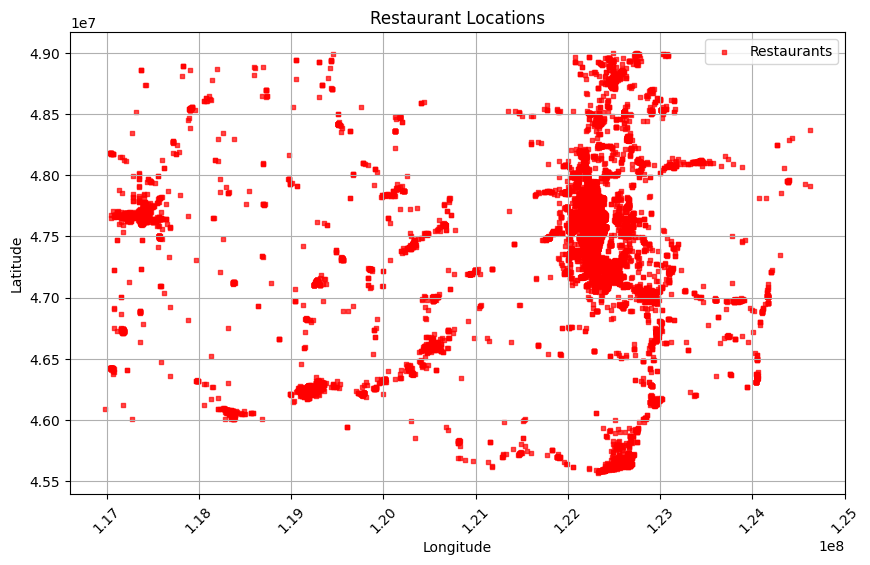

In [7]:
# Plot all restaurant locations
plt.figure(figsize=(10, 6))
plt.scatter(restaurant_data['Longitude'], restaurant_data['Latitude'], label='Restaurants', color='red', marker='s', s=10, alpha=0.7)

# Add title and labels
plt.title('Restaurant Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

##### Restaurants with People's Paths

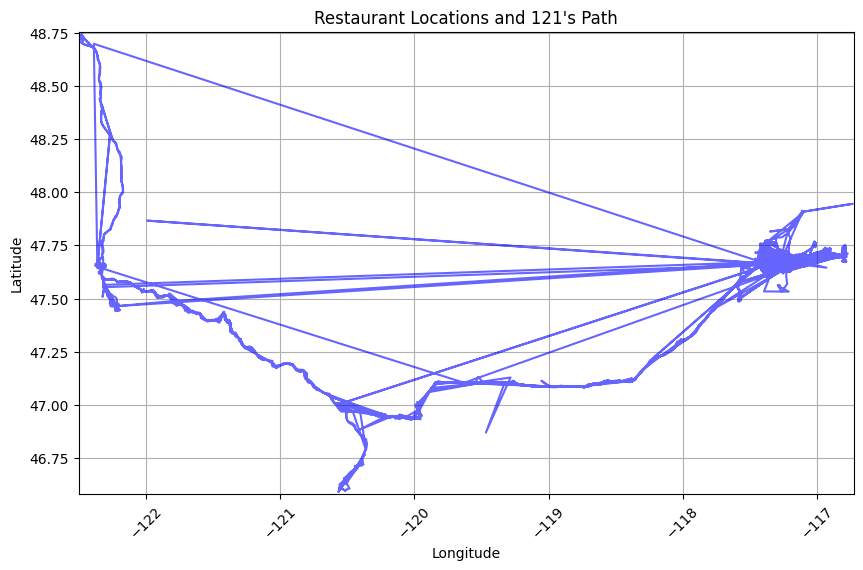

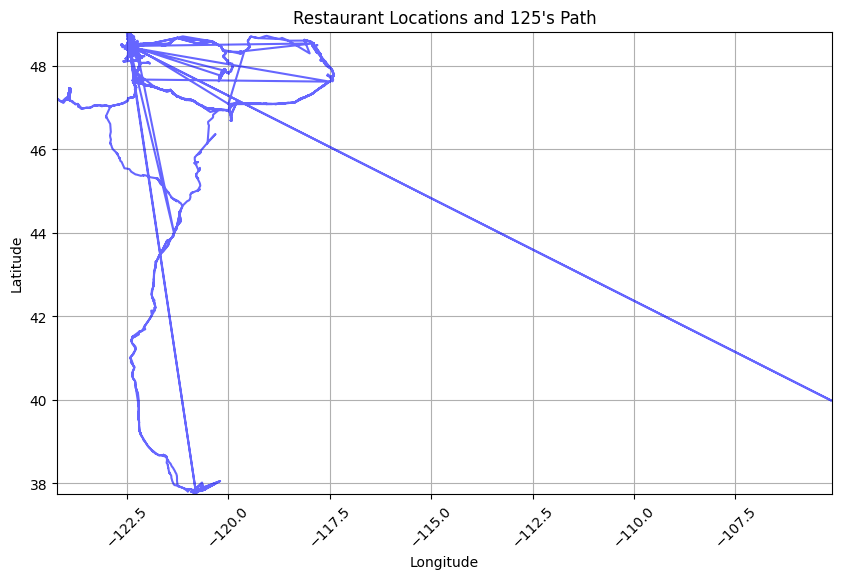

In [ ]:
# Plot the restaurant locations and paths
grouped_movements_data = movements_data.groupby('id')
for name, group in grouped_movements_data:
    plt.figure(figsize=(10, 6))
    
    # Plot the restaurant locations
    
    plt.scatter(restaurant_data['Longitude'], restaurant_data['Latitude'], label='Restaurants', color='red', marker='s', s=10, alpha=0.7)
    # Plot the person's path
    person_data = group.dropna(subset=['longitude', 'latitude'])
    plt.plot(person_data['longitude'], person_data['latitude'], label=f'Path of {name}', color='blue', alpha=0.6)
    
    # Set the limits of the plot to focus on the person's path
    plt.xlim(person_data['longitude'].min() - 0.01, person_data['longitude'].max() + 0.01)
    plt.ylim(person_data['latitude'].min() - 0.01, person_data['latitude'].max() + 0.01)

    # Add title and labels
    plt.title(f'Restaurant Locations and {name}\'s Path')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    # plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
    # # Count the number of visits to each location
    # visit_counts = person_data.groupby(['longitude', 'latitude']).size().reset_index(name='counts')

    # # Plot the restaurant locations with visit weights
    # plt.figure(figsize=(10, 6))
    # plt.scatter(restaurant_data['Longitude'], restaurant_data['Latitude'], label='Restaurants', color='red', marker='s',s=1, alpha=0.7)
    # plt.scatter(visit_counts['longitude'], visit_counts['latitude'], s=visit_counts['counts']*10, label=f'Path of {name}', color='blue', alpha=0.6)

    # # Add title and labels
    # plt.title(f'Restaurant Locations and {name}\'s Path with Visit Weights')
    # plt.xlabel('Longitude')
    # plt.ylabel('Latitude')
    # plt.legend()
    # plt.xticks(rotation=45)
    # plt.grid(True)
    # plt.show()
    
    # display(visit_counts.sort_values(by='counts', ascending=False).head(10))